In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.SN_Curve import SN_Curve_qats

In [3]:
from utils.create_geo_matrix import create_geo_matrix
from utils.transformations import global_2_compass, compass_2_global
from utils.get_scf_sector_list import get_scf_sector_list

In [4]:
import numpy as np
import sys
import pandas as pd
import os

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [30 / 2.54, 20 / 2.54]
pd.set_option('display.width', 1000) # Print columns wider
pd.set_option('display.max_rows', 500) # Print more rows

### Pre-define data paths, global variables etc.

In [6]:
# Get relevant data_paths for DLC and simulation result files
data_path     = fr'{os.getcwd()}\data'
member_geometry_file_path = data_path +  r'\DA_P53_CD_members.xlsx'
sectors  = [float(i) for i in range(0,359,15)] 

# Extract file for all DEM sums per geo, per elevation
DEM_data_path = fr'{os.getcwd()}\output\python_combined_DEM.xlsx'
df_xlsx = pd.read_excel(DEM_data_path)

# Define DEM variables
T_lifetime = 25.75 # 27.08
N_equivalent = 1e7
wohler_exp = 5.0
curve = SN_Curve_qats('D-air')
DFF = 3.0
# plt.figure(dpi=96)
# SN_Curve_qats('D-air').plot_characteristics()
# SN_Curve_qats('D-cath').plot_characteristics()

### Extract hotspot geometry

In [7]:
geo_test_df = pd.read_excel(fr'{os.getcwd()}\unused\DA_P53_CD copy with extra geo.xlsx')
top_boat_landing_geo = create_geo_matrix(geo_test_df, sectors)[0]
elevation_boat_landing = top_boat_landing_geo['elevation']

### Define angles in both turbine frame and compass frame

In [8]:
# Translate the angles to compass angles to align with given SCF factor
# NOTE dont really need these
global_angles = [float(key) for key in df_xlsx.iloc[0][1:].keys()] # 1: due to element 0 being 'mLat'
compass_angles = global_2_compass(global_angles)
adjusted_compass_angles, scf_sectors = top_boat_landing_geo['adjusted_angles'], top_boat_landing_geo['scf_per_point']
adjusted_global_angles = compass_2_global(adjusted_compass_angles)
validate_df = pd.DataFrame(data=np.hstack((np.array([adjusted_compass_angles]).reshape(-1,1), 
                                np.array([scf_sectors]).reshape(-1,1), 
                                np.array([adjusted_global_angles]).reshape(-1,1))), 
                                columns = ['Adjusted compass angles', 'SCF','Adjusted global angles'])

### Preliminary check of the members: polar plot of DEM per sector, for all elevations

In [9]:
member_elevations = np.array([float(key) for key in (df_xlsx['mLat'].values)])
DEM_tot_all_members_all_angles = np.array( [((T_lifetime / N_equivalent * np.array(df_xlsx.iloc[idx][1:]))**(1 / wohler_exp)) for idx, _ in enumerate(member_elevations)])

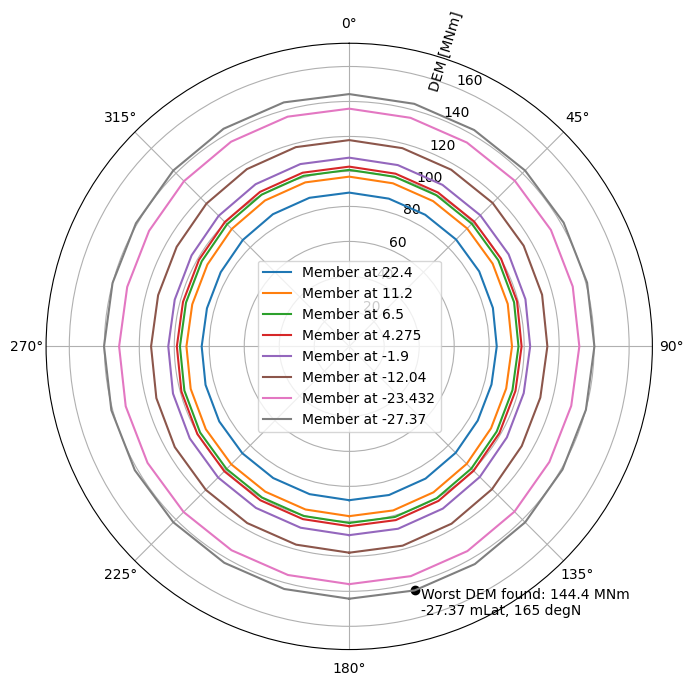

In [10]:
polar_compass_angles = np.deg2rad(compass_angles)
worst_elevation_idx = divmod(DEM_tot_all_members_all_angles.argmax(), DEM_tot_all_members_all_angles.shape[1])[0]
worst_sector_on_worst_elevation_idx = DEM_tot_all_members_all_angles[worst_elevation_idx].argmax()
worst_elevation = member_elevations[worst_elevation_idx]
worst_sector_on_worst_elevation = compass_angles[worst_sector_on_worst_elevation_idx]
worst_sector_on_worst_elevation_rad = polar_compass_angles[worst_sector_on_worst_elevation_idx]
worst_overall_DEM_all_elevations = DEM_tot_all_members_all_angles[worst_elevation_idx, worst_sector_on_worst_elevation_idx]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")  # theta = 0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise

for elevation_idx, DEM_at_elevation_i in enumerate(DEM_tot_all_members_all_angles):
    plotting_angles_rad = np.concatenate( (polar_compass_angles, polar_compass_angles[[0]]) )
    plotting_vals_MNm = np.concatenate( (DEM_at_elevation_i, DEM_at_elevation_i[[0]])) / 1e6
    ax.plot(plotting_angles_rad, plotting_vals_MNm, label = f'Member at {member_elevations[elevation_idx] }')

ax.scatter(worst_sector_on_worst_elevation_rad, DEM_tot_all_members_all_angles[worst_elevation_idx, worst_sector_on_worst_elevation_idx] / 1e6, color='black')
ax.text(worst_sector_on_worst_elevation_rad, worst_overall_DEM_all_elevations / 1e6 * 1.1, s = f'Worst DEM found: {worst_overall_DEM_all_elevations / 1e6:.1f} MNm \n{member_elevations[elevation_idx]} mLat, {worst_sector_on_worst_elevation:.0f} degN', color='black')
ax.set_rmax(DEM_tot_all_members_all_angles.max() * 1.2 / 1e6)  
ax.set_rlabel_position(45 / 2) 
ax.text(np.deg2rad(45 / 2 * 0.75), worst_overall_DEM_all_elevations / 1e6 * 1.06, s = f'DEM [MNm]', color='black', rotation = 90 - 45/2 * 0.75)
_ = plt.legend()

### Plot the largest DEM per elevation for the turbine's TP and MP

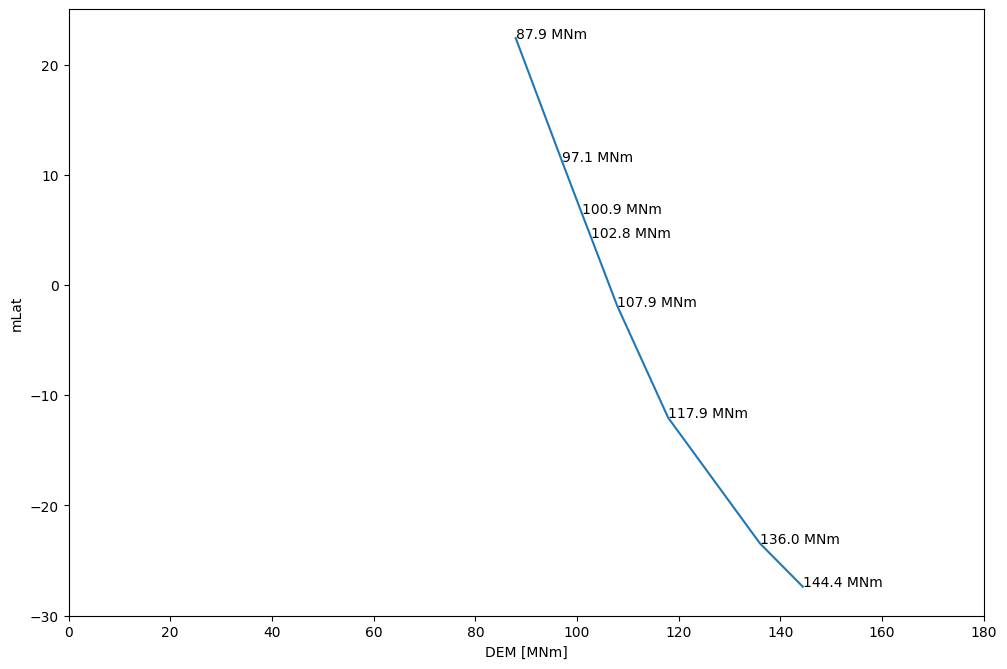

In [11]:
fig, ax = plt.subplots()
lst = np.array([ [DEM_at_elevation_i.max() / 1e6, member_elevations[elevation_idx]] for elevation_idx, DEM_at_elevation_i in enumerate(DEM_tot_all_members_all_angles)])
x, y = lst[:,0], lst[:, 1]
plt.plot(x,y)
plt.ylim(-30, 25)
plt.xlim(0, 180)
plt.ylabel('mLat')
plt.xlabel('DEM [MNm]')
for pos in lst:
    plt.text(pos[0], pos[1], s=f'{pos[0]:.1f} MNm')

### Extract pre computed DEM data - use boat landing geometry - find member_elevations of nodes above and below boat landing

In [12]:
dist = member_elevations - elevation_boat_landing
assert (np.any(dist >= 0.)), 'Geo in question is above the highest node - invalid for interpolation'
assert (np.any(dist < 0.)), 'Geo in question is below the lowest node - invalid for interpolation'

In [13]:
idx_above = np.ma.MaskedArray(dist, dist < 0.0).argmin() # mask out values below 0, and find the positive value closest to zero
idx_below = np.ma.MaskedArray(dist, dist >= 0.0).argmax() # mask out values above 0, and find the negative value closest to zero
idx_closest = np.abs(dist).argmin()

elevation_above = member_elevations[idx_above]
elevation_below = member_elevations[idx_below]
elevation_closest = member_elevations[idx_closest]
                             
print(f'The nodes from the DEM calculation closest to boat landing at {elevation_boat_landing:.2f} mLat is \n{elevation_above:.2f} @ mLat above \n{elevation_below:.2f} @ mLat below')
closest_is_above = elevation_closest > elevation_boat_landing
print(f'The closest of elevations is {elevation_closest}, {"above" if closest_is_above else "below"} the boat landing')

The nodes from the DEM calculation closest to boat landing at 9.69 mLat is 
11.20 @ mLat above 
6.50 @ mLat below
The closest of elevations is 11.2, above the boat landing


### Extract DEM from the neighbouring elevations

In [14]:
# Manually find DEM interpolated for 9.69 mLat by using manually chosen elevations
above_DEM = np.array(df_xlsx.iloc[idx_above][1:]) # remove the mLat dimension of the DataFrame - this will be a np.array with DEM for all (24) sectors
below_DEM = np.array(df_xlsx.iloc[idx_below][1:])

# Linear interpol; DEM_i = DEM_below + [dy/dx] * dx = DEM_below + [(delta DEM above/below) / (delta elevation above/below) ] * (elevation geo i - elevation below) or DEM_below + interpol_factor * delta DEM
interpol_factor = (elevation_boat_landing - elevation_below) / (elevation_above - elevation_below) # TODO use scipy or numpy interpolation function? Or keep this for readability

## Use the interpolated DEM to calculate the factor to scale moment ranges with accordingly

In [15]:
# Calculate total DEM for above, current and below elevations, for all sectors (n_sectors, )-shaped
DEM_above_tot = ((T_lifetime / N_equivalent * above_DEM)**(1 / wohler_exp))
DEM_below_tot = ((T_lifetime / N_equivalent * below_DEM)**(1 / wohler_exp))
DEM_boat_landing_tot = DEM_below_tot + (DEM_above_tot - DEM_below_tot) * interpol_factor

### Find the reference DEM and scaling factor / scaled DEM in hotspot

In [16]:
# Find above and below
DEM_hotspot_vs_above = np.array(DEM_boat_landing_tot / DEM_above_tot) # per sector
f_hotspot_vs_above = DEM_hotspot_vs_above.max()
DEM_hotspot_vs_below = np.array(DEM_boat_landing_tot / DEM_below_tot)
f_hotspot_vs_below = DEM_hotspot_vs_below.max()

In [17]:
# Choose the reference according to closest elevation
# TODO should we choose worst, or the closest to 
# And how do we select the sector on the hotspot elevation BEFORE we know the worst DEM on that elevation? Just choose an angle with the highest SCF?

DEM_reference_factor = f_hotspot_vs_above if closest_is_above else f_hotspot_vs_below
sector_idx_for_worst_reference_DEM = DEM_hotspot_vs_above.argmax() if closest_is_above else DEM_hotspot_vs_below.argmax()
DEM_reference = DEM_above_tot[sector_idx_for_worst_reference_DEM] if closest_is_above else DEM_below_tot[sector_idx_for_worst_reference_DEM]
DEM_hotspot_interpolated = DEM_reference * DEM_reference_factor

print(f'DEM relationships above and below')
DEM_hotspot_report = 98.2 * 1.00772 * 1e6
utilization_hotspot_report = 0.799
print(f'From report: above vs. hotspot 98.2 MNm * 1.00772 ~ {DEM_hotspot_report * 1e-6:.1f} MNm')
# print(f'Above : {f_hotspot_vs_above} at ang {global_angles[DEM_hotspot_vs_above.argmax() ]} / {compass_angles[DEM_hotspot_vs_above.argmax()]} degN')
# print(f'Below: {f_hotspot_vs_below} at ang {global_angles[ DEM_hotspot_vs_below.argmax() ] } / {compass_angles[DEM_hotspot_vs_below.argmax()]} degN')
print('#'*40)
print(f'Chosing factor {"above" if closest_is_above else "below"} as reference, with reference M_eq = {DEM_reference / 10**6:.2f} MNm at {compass_angles[DEM_hotspot_vs_above.argmax()]} degN')
print(f'Interpolated DEM at hotspot with factor {DEM_reference_factor:5f} gives M_scf = {DEM_hotspot_interpolated / 10**6:.2f} MNm')
fff = DEM_hotspot_interpolated / DEM_hotspot_report
print(f'Our Meq_hotspot as a fraction of report: {fff * 100:.4f} %')
print(f'Expecting our damage to be a factor f^m = {((fff)**wohler_exp):.4f} of the report at {utilization_hotspot_report * 100:.1f} %')
print(f'so our results should be close to {utilization_hotspot_report * (fff)**wohler_exp * 100:.1f} % util (m=5) to {utilization_hotspot_report * (fff)**3.0 * 100:.1f} % util (m=3')

DEM relationships above and below
From report: above vs. hotspot 98.2 MNm * 1.00772 ~ 99.0 MNm
########################################
Chosing factor above as reference, with reference M_eq = 97.04 MNm at 180.0 degN
Interpolated DEM at hotspot with factor 1.012851 gives M_scf = 98.28 MNm
Our Meq_hotspot as a fraction of report: 99.3171 %
Expecting our damage to be a factor f^m = 0.9663 of the report at 79.9 %
so our results should be close to 77.2 % util (m=5) to 78.3 % util (m=3


## Load the markov matrices with moment ranges and counts

In [18]:
# Load the markov matrices
from utils.fastnumpyio import load as fastio_load 
markov_path = fr'{os.getcwd()}\output\total_markov_member' + '{}.npy'
# mbr_to_el_map = {54: 22.4, 72: 11.2, 84: 6.5, 91: 4.275} # TODO this should be handled by the geometry file

member_geometry = pd.read_excel(member_geometry_file_path)
mbr_to_el_map = {k: v for k, v in zip(member_geometry['member_JLO'], member_geometry['elevation'])}

markov_matrices = {}
for mbr in mbr_to_el_map.keys():
    path = markov_path.format(mbr)
    markov_matrices[mbr_to_el_map[mbr]] = np.array(fastio_load(path))

### Pick the markov matrix from the reference node, AT THE WORST SECTOR

In [19]:
reference_elevation = elevation_above if closest_is_above else elevation_below
markov_at_reference_elevation = markov_matrices[reference_elevation]
markov_reference = markov_at_reference_elevation[sector_idx_for_worst_reference_DEM]
markov_reference = markov_reference[ markov_reference[:, 0].argsort()]

### Check if it is possible to recreate the DEM at the reference elevation with the loaded ranges

In [20]:
reference_moment_ranges = markov_reference[:,[0]]
reference_counts = markov_reference[:,[1]]
DEM_reference_recreated = float((T_lifetime / N_equivalent * ((reference_moment_ranges.T)**wohler_exp).dot(reference_counts))**(1 / wohler_exp))

print(f'Recreated stats from the reference markov matrix at {elevation_closest:.2f} mLat:')
print(f'Total counts over {T_lifetime:.0f} years: {reference_counts.sum() * T_lifetime / 10**6:.2f} * 10^6')
print(f'Total bins with nonzero counts: {np.count_nonzero(reference_counts)}')
print(f'Smallest M_range: {reference_moment_ranges.min() * 1e-6:.2f} MNm') 
print(f'Median M_range: {np.median(reference_moment_ranges) * 1e-6:.2f} MNm') 
print(f'Largest M_range: {reference_moment_ranges.max() * 1e-6:.2f} MNm') 
print(f'Recreated DEM at reference for m = 5: {(DEM_reference_recreated) / 10**6 :.2f} MNm')
print(f'Original DEM at reference for m = 5: {DEM_reference / 10**6 :.2f} MNm')
print(f'It is {"possible" if ((DEM_reference - DEM_reference_recreated) < 1e-6) else "not possible"} to recreate DEM')

Recreated stats from the reference markov matrix at 11.20 mLat:
Total counts over 26 years: 168.89 * 10^6
Total bins with nonzero counts: 745768
Smallest M_range: 0.14 MNm
Median M_range: 46.18 MNm
Largest M_range: 401.38 MNm
Recreated DEM at reference for m = 5: 97.04 MNm
Original DEM at reference for m = 5: 97.04 MNm
It is possible to recreate DEM


### Rescale the moment ranges for the nearest hotspot according to the DEM relation, and find corresponding stress ranges

In [21]:
# Scale all moment ranges per sector according to relationships calculated above, or just one single factor determined by DEM max. Test below, above and closest
markov_hotspot = markov_reference.copy()
markov_hotspot[:, [0]] = markov_reference[:, [0]] * DEM_reference_factor # could use *= but this stays in control "compunding interest" when using notebooks
DEM_hotspot_recreated = ( T_lifetime / N_equivalent * ((markov_hotspot[:,[0]].T)**wohler_exp).dot(markov_hotspot[:,[1]]) )**(1 / wohler_exp)

print(f'Largest M_range: {markov_hotspot[:, 0].max() * 1e-6:.2f} MNm') 
print(f'Recreated DEM at hotspot for m = 5: {float(DEM_hotspot_recreated) / 10**6 :.2f} MNm')
print(f'Original DEM at hotspot for m = 5: {DEM_hotspot_interpolated / 10**6 :.2f} MNm')
print(f'It is {"possible" if ((DEM_hotspot_recreated - DEM_hotspot_interpolated) < 1e-6) else "not possible"} to recreate DEM')

Largest M_range: 406.53 MNm
Recreated DEM at hotspot for m = 5: 98.28 MNm
Original DEM at hotspot for m = 5: 98.28 MNm
It is possible to recreate DEM


## Use the hotspot moment ranges to calculate all stress ranges

In [39]:
stress_ranges_nominal = markov_hotspot[:, [0]] * top_boat_landing_geo['D'] / (2 * top_boat_landing_geo['I'])

[[3.45334980e+04]
 [3.53720896e+04]
 [3.64981653e+04]
 ...
 [9.89517099e+07]
 [9.97401697e+07]
 [1.00528630e+08]]


### Scale stress ranges according to SCF and effective thickness

In [41]:

# Scale stress ranges according to SCF
scf_factor = np.max(scf_sectors) # TODO solve this for the closest point at hotspot elevation
alpha = top_boat_landing_geo['alpha']
stress_ranges_scaled = stress_ranges_nominal * scf_factor * alpha * top_boat_landing_geo['grit_blasting']
stress_ranges_MPa = stress_ranges_scaled / 1e6

[[6.04164858e-02]
 [6.18836050e-02]
 [6.38536787e-02]
 ...
 [1.73116392e+02]
 [1.74495805e+02]
 [1.75875219e+02]]


In [38]:
# Use stress ranges in miner summation for damage (see reports)
T_lifetime_util = 25.75 # 27.08
total_hotspot_counts = markov_hotspot[:, [1]] * T_lifetime_util
stress_ranges_and_counts = np.hstack( (stress_ranges_MPa, total_hotspot_counts) )
in_place_hotspot_utilization = curve.miner_sum(stress_ranges_and_counts) * DFF
print(f'Total in-place damage of hotspot = {in_place_hotspot_utilization * 100.0:.2f} %')
print(f'This means that RULe damage is a factor {in_place_hotspot_utilization / utilization_hotspot_report * 100:.2f} of report damage')

Total in-place damage of hotspot = 76.34 %
This means that RULe damage is a factor 95.54 of report damage


### Extra: recreating damage from the WTP report

In [25]:
tableE80 = pd.read_excel(fr'{os.getcwd()}\unused\tableE80.xlsx')

In [26]:
comp_df = pd.DataFrame()
comp_df["Smin"] = tableE80["Smin,HS"]
comp_df["Smax"] = tableE80["Smax,HS"]
comp_df["Srange"] = tableE80["Srange,HS"]
comp_df["Smean"] = (comp_df["Smin"] + comp_df["Smax"]) / 2
comp_df["count"] = tableE80["Nair"]
comp_df["D_table"] = tableE80["Dair"]

In [27]:
def get_damage(stress_range, count):
    return DFF * curve.miner_sum(np.array([[stress_range, count]])) 

In [28]:
# Mean stress correction
# uts = 420.0
# comp_df["Srange_corr"] = comp_df["Srange"] * uts / (uts - comp_df["Smean"])
# comp_df["D_corr"] = comp_df.apply(lambda row: get_damage(row["Srange_corr"] * alpha, row["count"]), axis=1)
# comp_df["D_diff_corr"] = ((comp_df["D_table"] - comp_df["D_corr"]) / comp_df["D_table"] * 100).map(lambda x: f'{x:.2f} %')

In [1]:
comp_df["D_recreated"] = comp_df.apply(lambda row: get_damage(row["Srange"] * alpha, row["count"]), axis=1)
comp_df["D_diff"] = (comp_df["D_table"] - comp_df["D_recreated"])
comp_df["D_diff_%"] = ((comp_df["D_table"] - comp_df["D_recreated"]) / comp_df["D_table"] * 100).map(lambda x: f'{x:.2f} %')

if False:
    with pd.option_context('display.precision', 2):
        print(comp_df.head())
        print(comp_df.tail())

NameError: name 'comp_df' is not defined

### How much difference do we have, and where does it come from?

In [30]:
deviation_SN_damage = comp_df["D_recreated"].sum() / comp_df["D_table"].sum()

In [31]:
explainable_diff = fff**wohler_exp * deviation_SN_damage

print(f'Trying to explain the deviation in damage, we see a factor of D_DEM = D * {fff**wohler_exp:.4f} coming from different DEM/markov,\nand on average a factor of D_DEM * {deviation_SN_damage:.4f} underestimation after miner summation SN differences')
print(f'The result is that RULe damage is a factor of {fff**wohler_exp:.4f} * {deviation_SN_damage:.4f} = {explainable_diff:.4f} of the report damage')

remaining_diff = explainable_diff - in_place_hotspot_utilization / utilization_hotspot_report
print(f'Hence, considering that the RULe damage for the hotspot was indeed a factor of {in_place_hotspot_utilization / utilization_hotspot_report:.4f}, the remaining unexplained damage is {remaining_diff*100:.4f} %')

Trying to explain the deviation in damage, we see a factor of D_DEM = D * 0.9663 coming from different DEM/markov,
and on average a factor of D_DEM * 0.9926 underestimation after miner summation SN differences
The result is that RULe damage is a factor of 0.9663 * 0.9926 = 0.9591 of the report damage
Hence, considering that the RULe damage for the hotspot was indeed a factor of 0.9554, the remaining unexplained damage is 0.3729 %


### Attempt of some recreation with our own cycles

In [32]:
n_bins = 1000
bins = np.linspace(0., markov_hotspot[:,0].max(), n_bins + 1)
bins_midpoints = 0.5 * (bins[:-1] + bins[1:]) # this is why n_bins + 1 is passed to linspace
bin_n, _ = np.histogram(markov_hotspot[:,0], bins = bins, range = None, weights = markov_hotspot[:,1])
print(f'{bin_n.sum() / 1e6 * 25:.2f} Mcounts')
binned_markov_hotspot = np.array([bins_midpoints, bin_n]).T

163.97 Mcounts


In [33]:
def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

def sci_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return f"{num:.2f} {['Nm', 'kNm', 'MNm', 'GNm'][magnitude]}" # '%.2f%s' % (num, ['Nm', 'kNm', 'MNm', 'GNm'][magnitude])

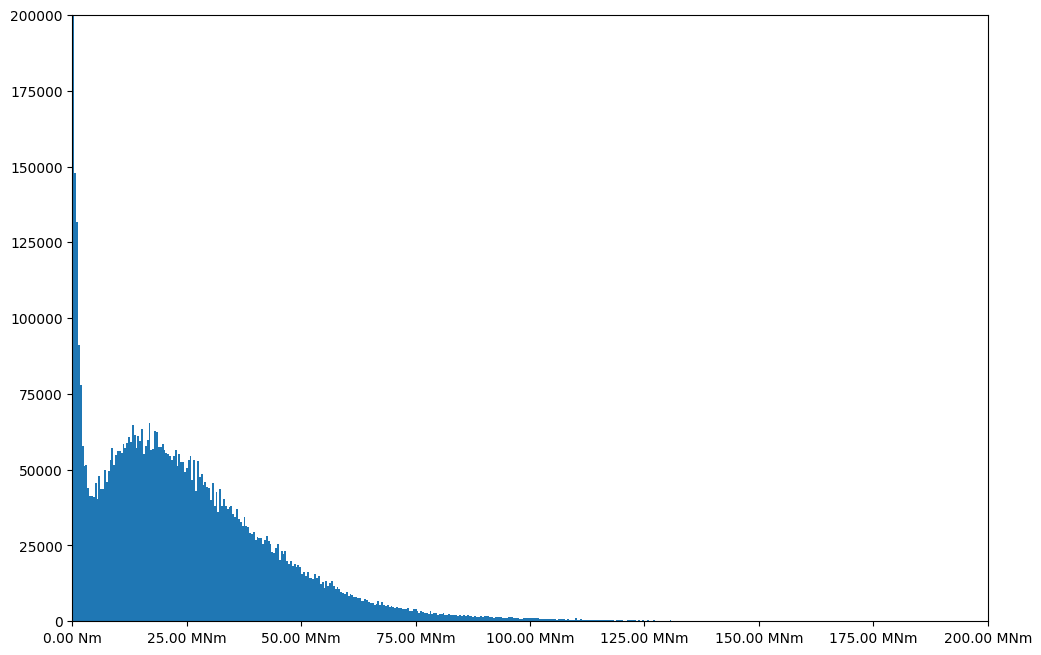

In [34]:
ranges, counts = binned_markov_hotspot.T
fig, ax = plt.subplots()
plt.hist(bins[:-1], bins, weights=counts)
plt.ylim((0, 20e4))
plt.xlim((0, 2e8))
import matplotlib.ticker as ticker
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: sci_format(x,pos)))


In [35]:
S_test = curve.SN.fatigue_strength(N_equivalent)

In [36]:
S_test

52.642115454076695